In [30]:
import os, random, json, PIL, shutil, re, imageio, glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
SEED = 0
seed_everything(SEED)

In [31]:
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 120
TRANSFORMER_BLOCKS = 6
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

In [32]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
print(f'REPLICAS: {REPLICAS}')

REPLICAS: 1


In [33]:
MONET_FILENAMES = tf.io.gfile.glob(str('./monet/gan-getting-started/monet_tfrec/monet*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str('./monet/gan-getting-started/photo_tfrec/photo*.tfrec'))
# MONET_FILENAMES = tf.io.gfile.glob(str(EXT_PATH + '/monet*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


In [34]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    
    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
      
    # Train on crops
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])
        
    
    return image

In [35]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(augment, num_parallel_calls=AUTO)
    dataset = dataset.map(normalize_img, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    
    return dataset

def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        f = plt.figure(figsize=(12, 12))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()
    
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)
        
        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')
        
        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')
        
        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')
        
    plt.show()

def create_gif(images_path, gif_path):
    images = []
    filenames = glob.glob(images_path)
    filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for epoch, filename in enumerate(filenames):
        img = PIL.ImageDraw.Image.open(filename)
        ImageDraw.Draw(img).text((0, 0),  # Coordinates
                                 f'Epoch {epoch+1}')
        images.append(img)
    imageio.mimsave(gif_path, images, fps=2) # Save gif
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [223]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=L.ReLU(), name='block_x'):
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = L.ReLU()(block)
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    
    block = L.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = L.Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    
    block = tf.pad(block, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC") # Works only with GPU
    block = L.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False,    
                     kernel_initializer=conv_initializer, 
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

In [224]:
def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=L.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_3')   # (bs, 64, 64, 256)
    
    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = L.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection
    
    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = L.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = L.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = L.Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = Model(inputs, outputs)
    
    return generator

sample_generator = generator_fn()
sample_generator.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder_block_1 (Conv2D)        (None, 256, 256, 64) 9408        input_image[0][0]                
__________________________________________________________________________________________________
re_lu_69 (ReLU)                 (None, 256, 256, 64) 0           encoder_block_1[0][0]            
__________________________________________________________________________________________________
encoder_block_2 (Conv2D)        (None, 128, 128, 128 73728       re_lu_69[0][0]                   
___________________________________________________________________________________________

In [225]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = L.Input(shape=[height, width, channels], name='input_image')
    #inputs_patch = L.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs) # Works only with GPU

    # Encoder    
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=L.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_2')       # (bs, 64, 64, 128)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_3')       # (bs, 32, 32, 256)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_4')       # (bs, 32, 32, 512)

    outputs = L.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)
    
    discriminator = Model(inputs, outputs)
    
    return discriminator


sample_discriminator = discriminator_fn()
sample_discriminator.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_block_1 (Conv2D)     (None, 128, 128, 64)      3072      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_block_2 (Conv2D)     (None, 64, 64, 128)       131072    
_________________________________________________________________
instance_normalization_46 (I (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
encoder_block_3 (Conv2D)     (None, 32, 32, 256)       524

In [226]:

monet_generator = generator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE, transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to Monet-esque paintings
photo_generator = generator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE, transformer_blocks=TRANSFORMER_BLOCKS) # transforms Monet paintings to be more like photos

monet_discriminator = discriminator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE) # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = discriminator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE) # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {'monet_gen_loss': total_monet_gen_loss,
                'photo_gen_loss': total_photo_gen_loss,
                'monet_disc_loss': monet_disc_loss,
                'photo_disc_loss': photo_disc_loss
               }

In [227]:
def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
def generator_loss(generated):
    return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

120 total epochs and 439 steps per epoch
Learning rate schedule: 0.0002 to 0.0002 to 5.7e-07


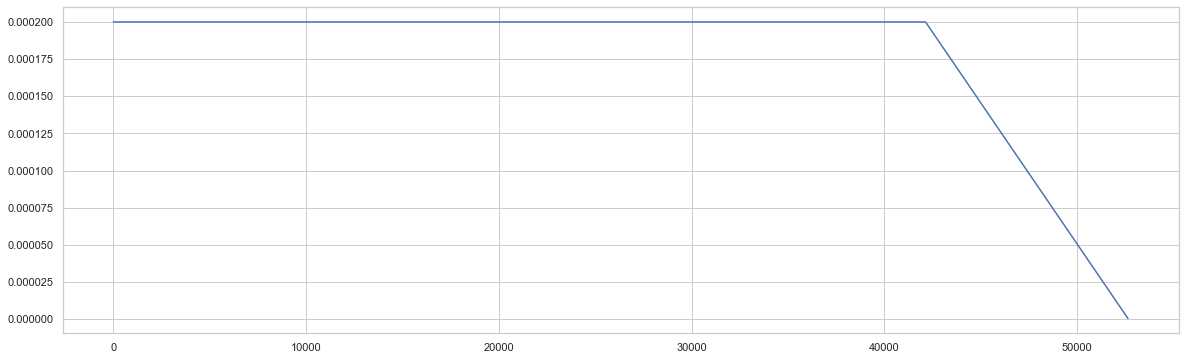

In [228]:
@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print(f'{EPOCHS} total epochs and {steps_per_epoch} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [229]:
lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
monet_generator_optimizer = optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

    # Create discriminators
lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
monet_discriminator_optimizer = optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)

    
    # Create GAN
gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)

In [230]:
monet_ds = get_dataset(MONET_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

photo_ds_eval = get_dataset(PHOTO_FILENAMES, repeat=False, shuffle=False, batch_size=1)
monet_ds_eval = get_dataset(MONET_FILENAMES, repeat=False, shuffle=False, batch_size=1)

# Callbacks
class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=1, monet_path='monet', photo_path='photo'):
        self.num_img = num_img
        self.monet_path = monet_path
        self.photo_path = photo_path
        # Create directories to save the generate images
        if not os.path.exists(self.monet_path):
            os.makedirs(self.monet_path)
        if not os.path.exists(self.photo_path):
            os.makedirs(self.photo_path)

    def on_epoch_end(self, epoch, logs=None):
        # Monet generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            prediction = monet_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.monet_path}/generated_{i}_{epoch+1}.png')
            
        # Photo generated images
        for i, img in enumerate(monet_ds_eval.take(self.num_img)):
            prediction = photo_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.photo_path}/generated_{i}_{epoch+1}.png')

In [231]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [232]:
history = gan_model.fit(gan_ds, 
                        epochs=EPOCHS, 
                        callbacks=[GANMonitor()], 
                        steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE), 
                        verbose=2).history

Epoch 1/120


ResourceExhaustedError:  OOM when allocating tensor with shape[16,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_14/decoder_block_2/conv2d_transpose_2 (defined at <ipython-input-226-e2396be1ebc6>:58) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_120514]

Function call stack:
train_function


In [46]:
from keras.models import load_model

In [47]:
load_model = load_model("monet_generator.h5")

(16, 128, 128, 3)
<dtype: 'float32'>
(16, 128, 128, 3)
<dtype: 'float32'>
(16, 128, 128, 3)
<dtype: 'float32'>
(16, 128, 128, 3)
<dtype: 'float32'>
(16, 128, 128, 3)
<dtype: 'float32'>
(16, 128, 128, 3)
<dtype: 'float32'>


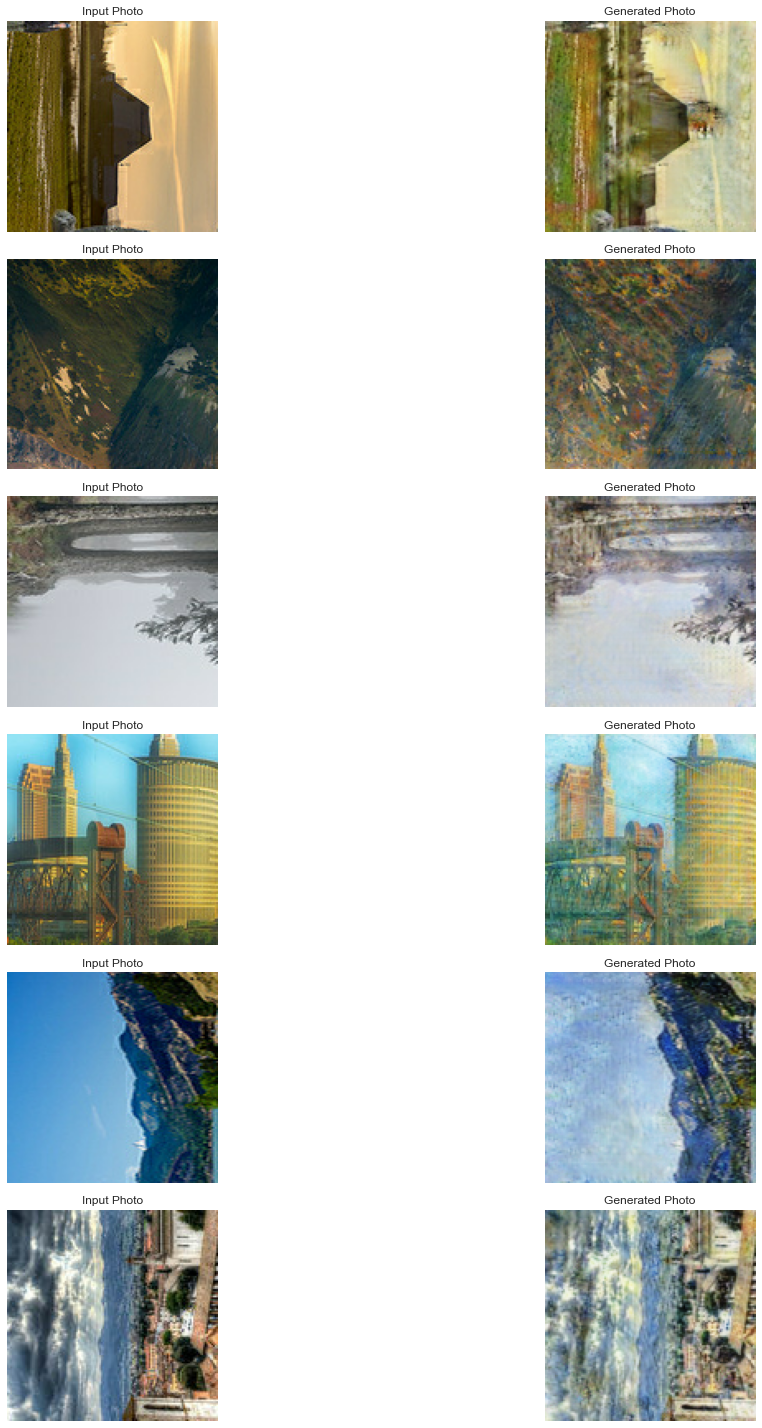

In [49]:
_, ax = plt.subplots(6,2,figsize = (20,20))
for i, img in enumerate(photo_ds.take(6)):
    print(img.shape)
    print(img.dtype)
    prediction = load_model(img, training = False)[0].numpy()
    prediction = prediction*0.5 + 0.5
    img = (img[0]*0.5 + 0.5).numpy()
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title('Input Photo')
    ax[i, 1].set_title('Generated Photo')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [51]:
photo_ds_eval.take(8)

<TakeDataset shapes: (None, 256, 256, 3), types: tf.float32>

In [52]:
photo_ds.take(8)

<TakeDataset shapes: (None, 128, 128, 3), types: tf.float32>

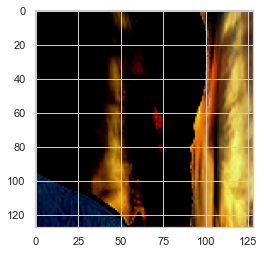

In [55]:
for i,img in enumerate(photo_ds.take(8)):
    plt.imshow(img[i])

(1, 128, 128, 3)
<dtype: 'float32'>
[[[0.7254902  0.6313726  0.6156863 ]
  [0.6745098  0.5882353  0.53333336]
  [0.69803923 0.6117647  0.52156866]
  ...
  [0.9098039  0.85490197 0.56078434]
  [0.8392157  0.77254903 0.49019608]
  [0.972549   0.90588236 0.6       ]]

 [[0.7607843  0.6509804  0.5568628 ]
  [0.9019608  0.78431374 0.6431373 ]
  [0.8980392  0.8235294  0.59607846]
  ...
  [0.6745098  0.654902   0.39607844]
  [0.827451   0.8        0.5176471 ]
  [0.8862745  0.8666667  0.5372549 ]]

 [[0.78039217 0.7411765  0.39215687]
  [0.9254902  0.85490197 0.5568628 ]
  [0.9372549  0.89411765 0.57254905]
  ...
  [0.85490197 0.8352941  0.5137255 ]
  [0.8784314  0.8509804  0.5372549 ]
  [0.92941177 0.9098039  0.5529412 ]]

 ...

 [[0.35686275 0.40784314 0.44313726]
  [0.3764706  0.41960785 0.44313726]
  [0.40784314 0.44705883 0.4509804 ]
  ...
  [0.7019608  0.70980394 0.42352942]
  [0.64705884 0.65882355 0.39607844]
  [0.59607846 0.60784316 0.39215687]]

 [[0.36078432 0.41568628 0.4509804 ]
 

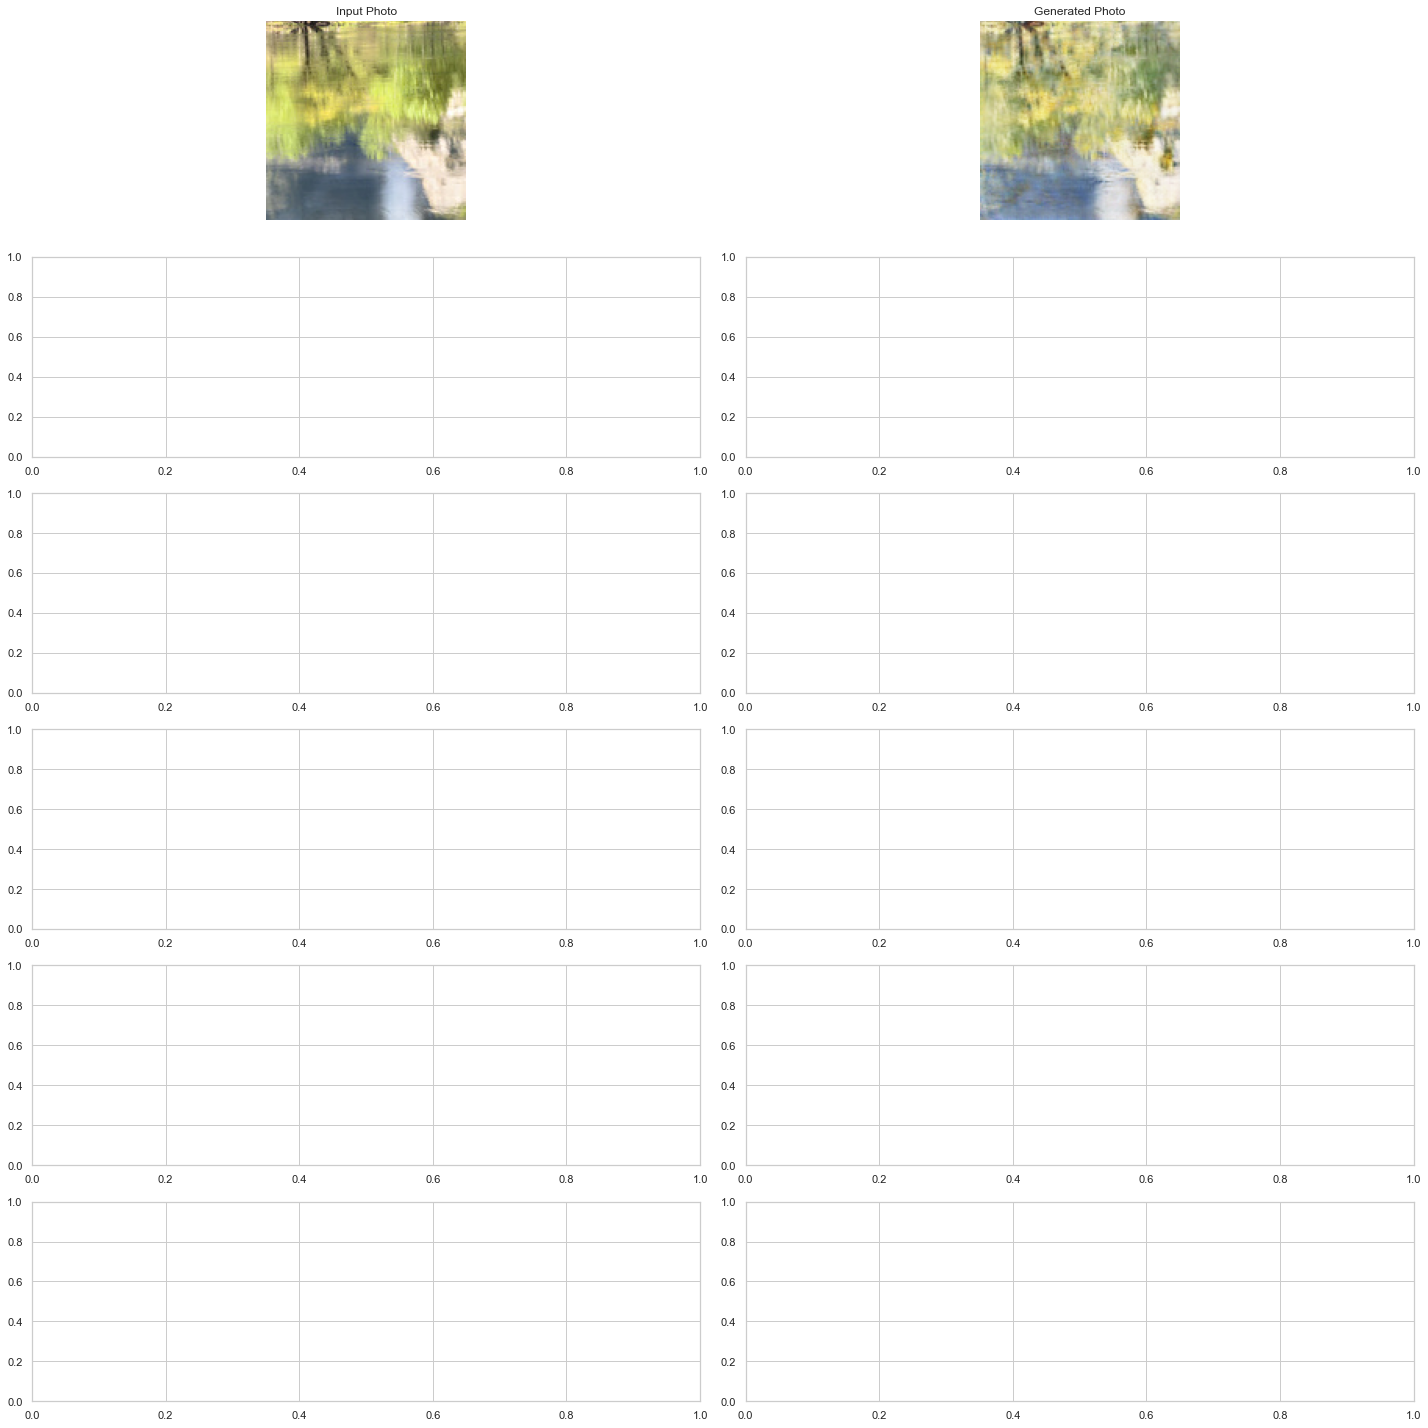

In [179]:
_, ax = plt.subplots(6,2,figsize = (20,20))
for i, img in enumerate(photo_ds.take(1)):
    print(img[:1].shape)
    print(img.dtype)
    prediction = load_model(img[:1], training = False)[0].numpy()
    prediction = prediction*0.5 + 0.5
    img = (img[0]*0.5 + 0.5).numpy()
    print(img)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title('Input Photo')
    ax[i, 1].set_title('Generated Photo')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [180]:
import cv2
import numpy as np
import matplotlib.image as mpimg

In [181]:
img = mpimg.imread('sunflower.jpg')

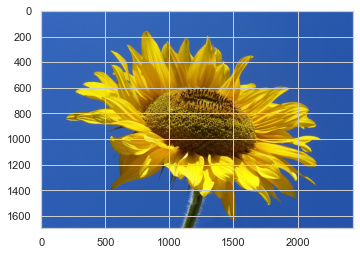

In [182]:
plt.imshow(img)

In [183]:
print(img.dtype)

uint8


In [184]:
img.shape

(1697, 2434, 3)

In [185]:
img = cv2.resize(img,(128,128))

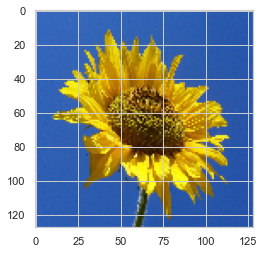

In [186]:
plt.imshow(img)

In [187]:
img.shape

(128, 128, 3)

In [188]:
img.dtype

dtype('uint8')

In [189]:
info = np.iinfo(img.dtype) # Get the information of the incoming image type
img = img.astype(np.float32) / info.max # normalize the data to 0 - 1
#img = 255 * img # Now scale by 255

In [190]:
print(img.dtype)

float32


In [191]:
imgs = []
imgs.append(img)
imgs = np.array(imgs)

In [192]:
imgs.shape
print(imgs.dtype)

float32


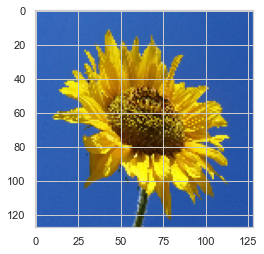

In [193]:
plt.imshow(imgs[0])

In [195]:
prediction = load_model(imgs, training = False)[0].numpy()

(1, 128, 128, 3)
float32


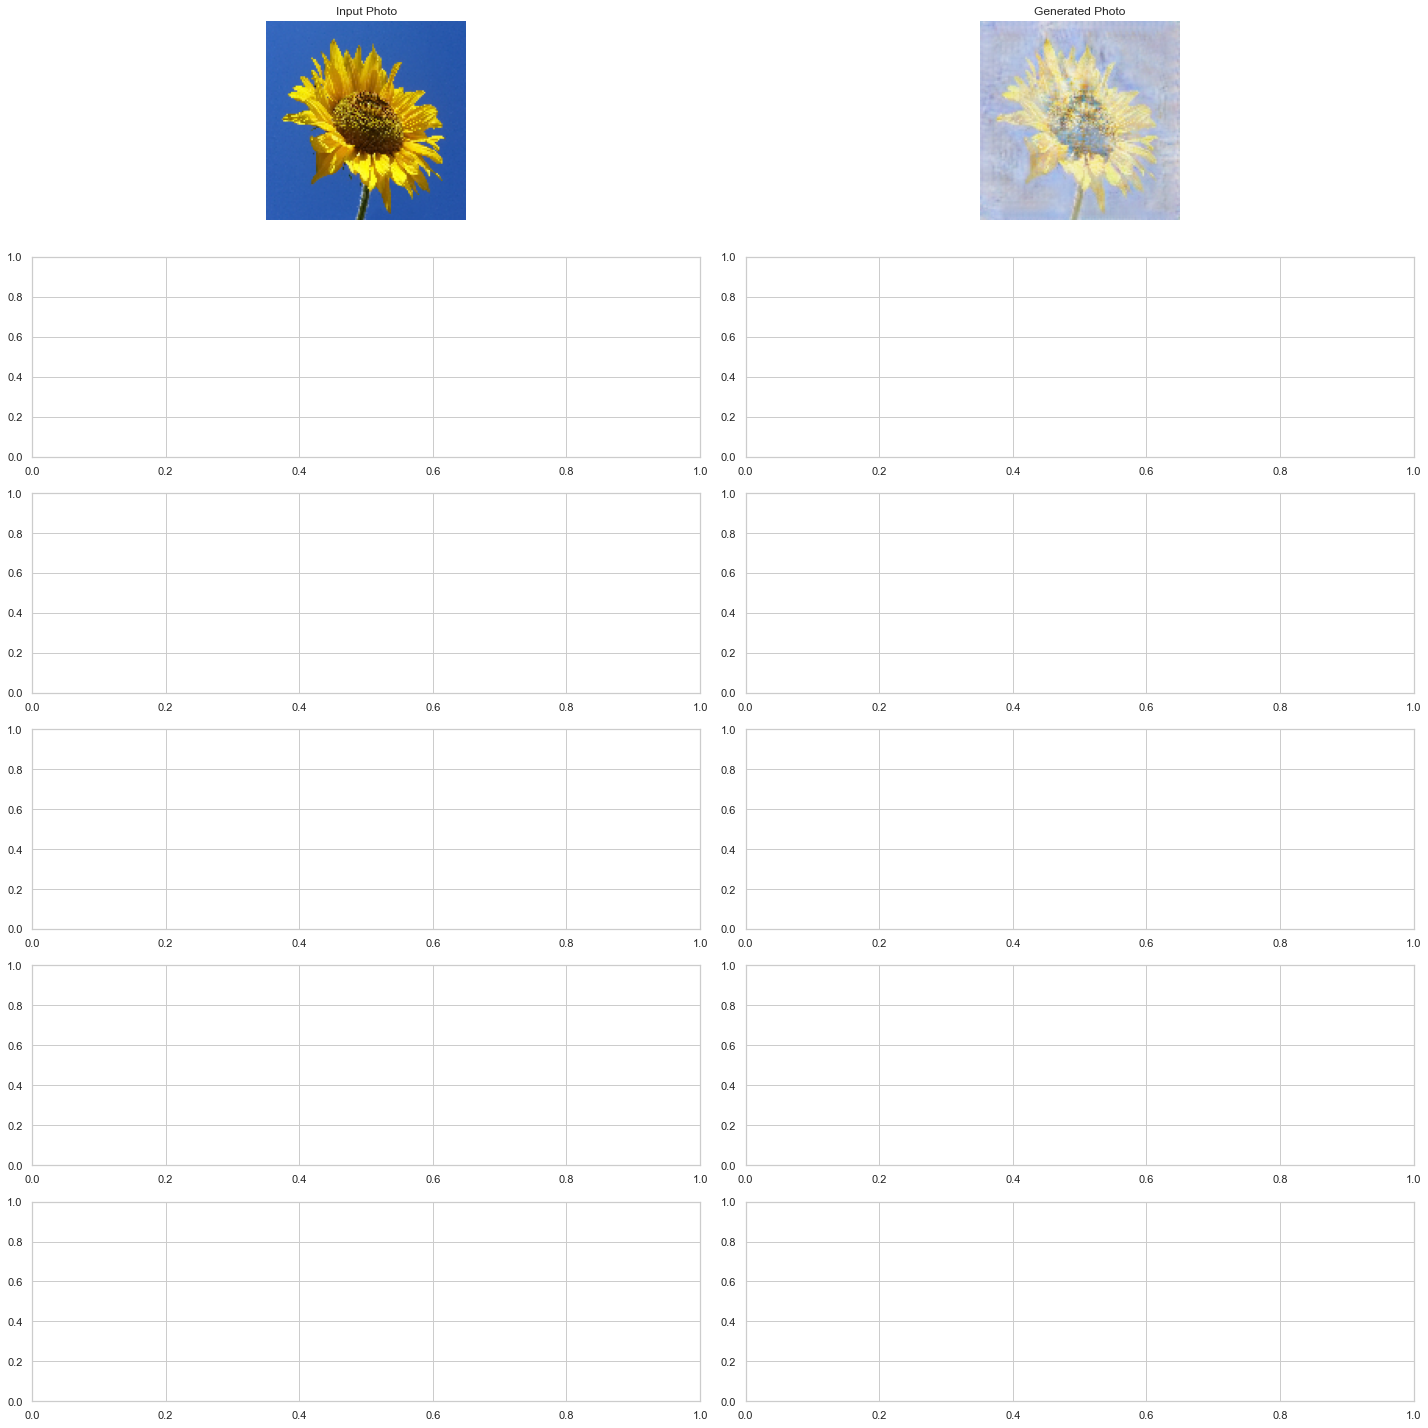

In [202]:
_, ax = plt.subplots(6,2,figsize = (20,20))
for i, img in enumerate(imgs):
    print(imgs.shape)
    print(imgs.dtype)
    prediction = load_model(imgs, training = False)[0].numpy()
    prediction = prediction*0.5 + 0.5
    #img = (img[0]*0.5 + 0.5).numpy()
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title('Input Photo')
    ax[i, 1].set_title('Generated Photo')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [194]:
img

array([[[0.20784314, 0.40392157, 0.74509805],
        [0.20784314, 0.40392157, 0.7529412 ],
        [0.22745098, 0.40784314, 0.7607843 ],
        ...,
        [0.16862746, 0.3529412 , 0.6745098 ],
        [0.15686275, 0.33333334, 0.6784314 ],
        [0.14509805, 0.32941177, 0.6784314 ]],

       [[0.21176471, 0.40784314, 0.7490196 ],
        [0.19215687, 0.4       , 0.73333335],
        [0.20784314, 0.40392157, 0.7490196 ],
        ...,
        [0.15294118, 0.34117648, 0.6745098 ],
        [0.15294118, 0.34117648, 0.6784314 ],
        [0.16078432, 0.34901962, 0.68235296]],

       [[0.21176471, 0.41568628, 0.7411765 ],
        [0.2       , 0.40784314, 0.7490196 ],
        [0.21176471, 0.4117647 , 0.7529412 ],
        ...,
        [0.15686275, 0.34117648, 0.6784314 ],
        [0.15686275, 0.3372549 , 0.67058825],
        [0.15686275, 0.34509805, 0.6745098 ]],

       ...,

       [[0.19607843, 0.3764706 , 0.70980394],
        [0.1764706 , 0.36862746, 0.7254902 ],
        [0.1882353 , 0

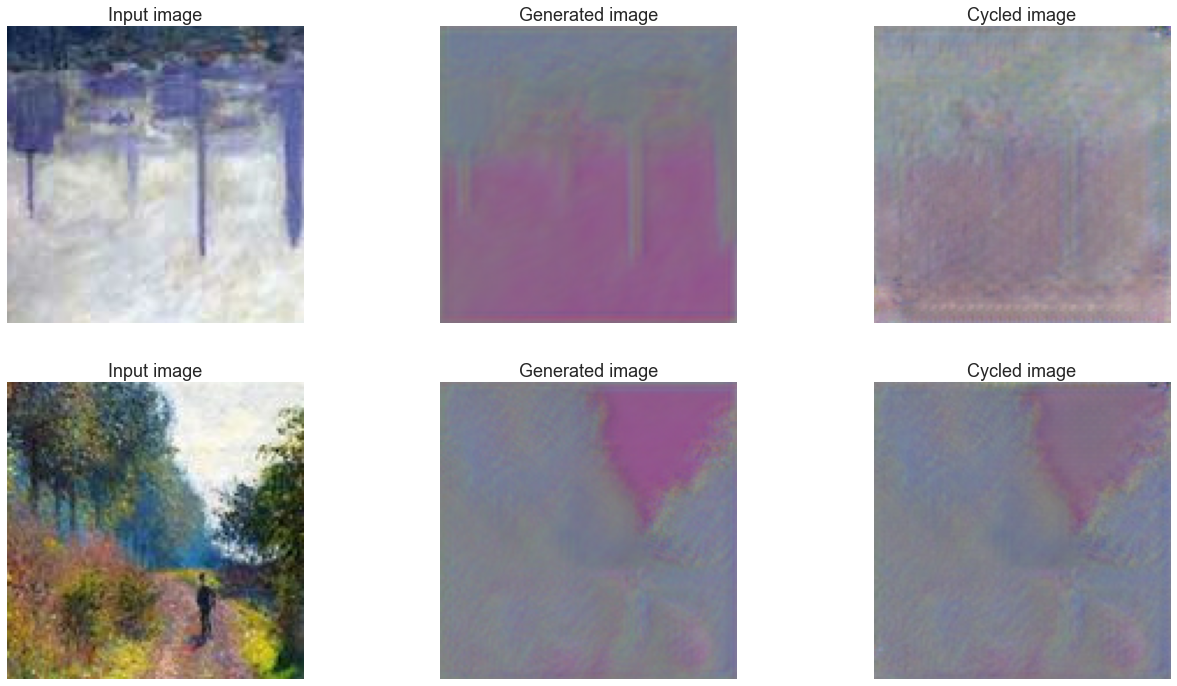

In [206]:
evaluate_cycle(monet_ds.take(2), photo_generator, load_model, n_samples=2)

In [263]:
X_data = []
files = glob.glob ("./*.jpg")
for myFile in files:
    print(myFile)
    img = mpimg.imread(myFile)
    img = cv2.resize(img,(128,128))
    info = np.iinfo(img.dtype)
    img = img.astype(np.float32) / info.max
    print(img.shape)
    X_data.append (img)

print('X_data shape:', np.array(X_data).shape)

.\003.3.jpg
(128, 128, 3)
.\127342-425x282-scenery.jpg
(128, 128, 3)
.\beautiful_scenery_04_hd_pictures_166258.jpg
(128, 128, 3)
.\rays-of-light-in-the-sky.jpg
(128, 128, 3)
.\sunflower.jpg
(128, 128, 3)
X_data shape: (5, 128, 128, 3)


In [264]:
X_data = np.array(X_data)

In [265]:
X_data.shape

(5, 128, 128, 3)

In [276]:
_, ax = plt.subplots(6,2,figsize = (100,100))
for i, img in enumerate(X_data):
    print(img.shape)
    print(img.dtype)
    prediction = load_model(X_data, training = False)[i].numpy()
    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title('Input Photo')
    ax[i, 1].set_title('Generated Photo')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

(128, 128, 3)
float32
(128, 128, 3)
float32


(128, 128, 3)
float32
(128, 128, 3)
float32


(128, 128, 3)
float32


In [251]:
prediction = load_model(X_data[0], training = False)[0].numpy()

ValueError: Input 0 is incompatible with layer model_2: expected shape=(None, 128, 128, 3), found shape=(128, 128, 3)

(1, 128, 128, 3)
float32


ValueError: Layer model_2 expects 1 input(s), but it received 6 input tensors. Inputs received: [<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.6509804 , 0.5058824 , 0.2509804 ],
        [0.6431373 , 0.50980395, 0.24313726],
        [0.65882355, 0.5176471 , 0.24313726],
        ...,
        [0.7411765 , 0.6509804 , 0.38039216],
        [0.7294118 , 0.6313726 , 0.3764706 ],
        [0.7294118 , 0.62352943, 0.36078432]],

       [[0.5921569 , 0.4627451 , 0.1882353 ],
        [0.60784316, 0.47058824, 0.2       ],
        [0.62352943, 0.4862745 , 0.20784314],
        ...,
        [0.7529412 , 0.6509804 , 0.39215687],
        [0.7372549 , 0.627451  , 0.3647059 ],
        [0.7294118 , 0.6156863 , 0.3529412 ]],

       [[0.6156863 , 0.47058824, 0.1882353 ],
        [0.59607846, 0.4627451 , 0.19215687],
        [0.6313726 , 0.4745098 , 0.20784314],
        ...,
        [0.73333335, 0.627451  , 0.36078432],
        [0.72156864, 0.61960787, 0.3529412 ],
        [0.7254902 , 0.6156863 , 0.34509805]],

       ...,

       [[0.03921569, 0.25882354, 0.21960784],
        [0.03529412, 0.07843138, 0.15686275],
        [0.03921569, 0.4392157 , 0.30980393],
        ...,
        [0.11372549, 0.5058824 , 0.45882353],
        [0.10196079, 0.46666667, 0.5686275 ],
        [0.14117648, 0.41960785, 0.5647059 ]],

       [[0.1764706 , 0.59607846, 0.6039216 ],
        [0.22352941, 0.61960787, 0.57254905],
        [0.13333334, 0.5372549 , 0.6392157 ],
        ...,
        [0.09019608, 0.49411765, 0.42352942],
        [0.1882353 , 0.5176471 , 0.50980395],
        [0.15294118, 0.5254902 , 0.47843137]],

       [[0.13333334, 0.52156866, 0.5372549 ],
        [0.11764706, 0.5294118 , 0.5372549 ],
        [0.12156863, 0.5882353 , 0.53333336],
        ...,
        [0.08627451, 0.43529412, 0.4627451 ],
        [0.03921569, 0.36078432, 0.3882353 ],
        [0.05882353, 0.45490196, 0.42745098]]], dtype=float32)>, <tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.10588235, 0.17254902, 0.27058825],
        [0.08235294, 0.12156863, 0.19215687],
        [0.0627451 , 0.09803922, 0.1764706 ],
        ...,
        [0.12156863, 0.32941177, 0.41568628],
        [0.1764706 , 0.36078432, 0.44705883],
        [0.20392157, 0.3764706 , 0.4627451 ]],

       [[0.07843138, 0.15686275, 0.2627451 ],
        [0.10980392, 0.16078432, 0.23529412],
        [0.07058824, 0.10980392, 0.1882353 ],
        ...,
        [0.1882353 , 0.34509805, 0.4392157 ],
        [0.19215687, 0.3529412 , 0.44313726],
        [0.19215687, 0.38039216, 0.44313726]],

       [[0.12156863, 0.2       , 0.3137255 ],
        [0.08235294, 0.13725491, 0.21568628],
        [0.0627451 , 0.11764706, 0.19215687],
        ...,
        [0.14117648, 0.3019608 , 0.39215687],
        [0.18039216, 0.36862746, 0.45490196],
        [0.24313726, 0.4117647 , 0.4117647 ]],

       ...,

       [[0.26666668, 0.3529412 , 0.31764707],
        [0.64705884, 0.70980394, 0.69803923],
        [0.8745098 , 0.9372549 , 0.9490196 ],
        ...,
        [0.03529412, 0.03137255, 0.13333334],
        [0.03137255, 0.03529412, 0.11764706],
        [0.08627451, 0.1254902 , 0.17254902]],

       [[0.18431373, 0.46666667, 0.42745098],
        [0.6666667 , 0.7411765 , 0.7294118 ],
        [0.88235295, 0.94509804, 0.95686275],
        ...,
        [0.03921569, 0.03137255, 0.14509805],
        [0.03529412, 0.03137255, 0.12941177],
        [0.07450981, 0.11764706, 0.17254902]],

       [[0.15686275, 0.4117647 , 0.39215687],
        [0.6117647 , 0.7058824 , 0.6862745 ],
        [0.8509804 , 0.91764706, 0.93333334],
        ...,
        [0.03529412, 0.03137255, 0.14509805],
        [0.03529412, 0.03137255, 0.13333334],
        [0.09019608, 0.1254902 , 0.1882353 ]]], dtype=float32)>, <tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.27450982, 0.2       , 0.11764706],
        [0.28235295, 0.2       , 0.11764706],
        [0.28235295, 0.20784314, 0.1254902 ],
        ...,
        [0.26666668, 0.23921569, 0.17254902],
        [0.26666668, 0.23921569, 0.17254902],
        [0.2509804 , 0.22352941, 0.15686275]],

       [[0.27058825, 0.2       , 0.10980392],
        [0.2784314 , 0.20392157, 0.12156863],
        [0.2901961 , 0.20784314, 0.1254902 ],
        ...,
        [0.27058825, 0.23921569, 0.17254902],
        [0.25882354, 0.23137255, 0.16078432],
        [0.2627451 , 0.23529412, 0.17254902]],

       [[0.2784314 , 0.20392157, 0.1254902 ],
        [0.2901961 , 0.20784314, 0.1254902 ],
        [0.29803923, 0.21568628, 0.13333334],
        ...,
        [0.28235295, 0.24705882, 0.19215687],
        [0.27450982, 0.24313726, 0.1764706 ],
        [0.2509804 , 0.22352941, 0.15686275]],

       ...,

       [[0.23529412, 0.23529412, 0.1882353 ],
        [0.2627451 , 0.2627451 , 0.21568628],
        [0.26666668, 0.30588236, 0.30588236],
        ...,
        [0.35686275, 0.4       , 0.3529412 ],
        [0.38039216, 0.44705883, 0.40392157],
        [0.3882353 , 0.4627451 , 0.44705883]],

       [[0.28627452, 0.34117648, 0.32156864],
        [0.28235295, 0.3254902 , 0.32156864],
        [0.3254902 , 0.38039216, 0.3882353 ],
        ...,
        [0.39215687, 0.4745098 , 0.47843137],
        [0.4       , 0.47843137, 0.48235294],
        [0.40392157, 0.4862745 , 0.49411765]],

       [[0.2784314 , 0.33333334, 0.3372549 ],
        [0.23529412, 0.29411766, 0.2901961 ],
        [0.3019608 , 0.38431373, 0.40392157],
        ...,
        [0.41568628, 0.5019608 , 0.49411765],
        [0.4       , 0.48235294, 0.4862745 ],
        [0.38431373, 0.47058824, 0.4627451 ]]], dtype=float32)>, <tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.74509805, 0.40392157, 0.20784314],
        [0.74509805, 0.40392157, 0.20784314],
        [0.75686276, 0.4117647 , 0.22352941],
        ...,
        [0.6745098 , 0.3529412 , 0.16862746],
        [0.6745098 , 0.3372549 , 0.15686275],
        [0.6784314 , 0.32941177, 0.14509805]],

       [[0.7490196 , 0.40784314, 0.21176471],
        [0.7372549 , 0.4       , 0.19607843],
        [0.74509805, 0.40392157, 0.20784314],
        ...,
        [0.6745098 , 0.34117648, 0.15294118],
        [0.6784314 , 0.34117648, 0.15294118],
        [0.68235296, 0.34901962, 0.16078432]],

       [[0.7411765 , 0.41568628, 0.21176471],
        [0.7490196 , 0.40392157, 0.20392157],
        [0.7529412 , 0.4117647 , 0.21568628],
        ...,
        [0.6784314 , 0.34117648, 0.15686275],
        [0.67058825, 0.3372549 , 0.15686275],
        [0.6784314 , 0.34509805, 0.15686275]],

       ...,

       [[0.7137255 , 0.3764706 , 0.19607843],
        [0.7254902 , 0.36862746, 0.1764706 ],
        [0.7058824 , 0.36862746, 0.1882353 ],
        ...,
        [0.6627451 , 0.32156864, 0.14509805],
        [0.6666667 , 0.32941177, 0.14509805],
        [0.6627451 , 0.32156864, 0.15686275]],

       [[0.7019608 , 0.3647059 , 0.18431373],
        [0.70980394, 0.3647059 , 0.16862746],
        [0.70980394, 0.3647059 , 0.18431373],
        ...,
        [0.6666667 , 0.32941177, 0.14901961],
        [0.6627451 , 0.32156864, 0.14117648],
        [0.6666667 , 0.32941177, 0.14901961]],

       [[0.70980394, 0.3647059 , 0.18039216],
        [0.7058824 , 0.36078432, 0.18039216],
        [0.7058824 , 0.3647059 , 0.16862746],
        ...,
        [0.65882355, 0.3254902 , 0.14901961],
        [0.6666667 , 0.3254902 , 0.15294118],
        [0.6666667 , 0.3254902 , 0.15294118]]], dtype=float32)>, <tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.14901961, 0.09803922, 0.04313726],
        [0.09019608, 0.05490196, 0.01960784],
        [0.08235294, 0.05098039, 0.01960784],
        ...,
        [0.05098039, 0.02745098, 0.        ],
        [0.05882353, 0.04313726, 0.00392157],
        [0.05882353, 0.03921569, 0.00784314]],

       [[0.18431373, 0.12941177, 0.05882353],
        [0.11764706, 0.07058824, 0.03137255],
        [0.07843138, 0.05490196, 0.02745098],
        ...,
        [0.05882353, 0.03529412, 0.00784314],
        [0.05882353, 0.03529412, 0.00784314],
        [0.05882353, 0.03529412, 0.00784314]],

       [[0.16862746, 0.12941177, 0.07450981],
        [0.07450981, 0.05882353, 0.03921569],
        [0.07843138, 0.05490196, 0.02745098],
        ...,
        [0.05098039, 0.02745098, 0.        ],
        [0.08235294, 0.03921569, 0.02352941],
        [0.10980392, 0.07058824, 0.04313726]],

       ...,

       [[0.01960784, 0.03921569, 0.03529412],
        [0.01960784, 0.03921569, 0.03529412],
        [0.01960784, 0.04313726, 0.02352941],
        ...,
        [0.10980392, 0.09411765, 0.05098039],
        [0.09019608, 0.07843138, 0.04705882],
        [0.09411765, 0.07450981, 0.04313726]],

       [[0.02352941, 0.03137255, 0.03137255],
        [0.02352941, 0.04313726, 0.03921569],
        [0.03529412, 0.05098039, 0.04313726],
        ...,
        [0.07058824, 0.07843138, 0.03921569],
        [0.08235294, 0.05882353, 0.03529412],
        [0.09411765, 0.07450981, 0.05490196]],

       [[0.02745098, 0.04313726, 0.03921569],
        [0.02745098, 0.03921569, 0.03921569],
        [0.02745098, 0.03529412, 0.03921569],
        ...,
        [0.08627451, 0.07058824, 0.05098039],
        [0.08235294, 0.07058824, 0.03921569],
        [0.09019608, 0.06666667, 0.03921569]]], dtype=float32)>]

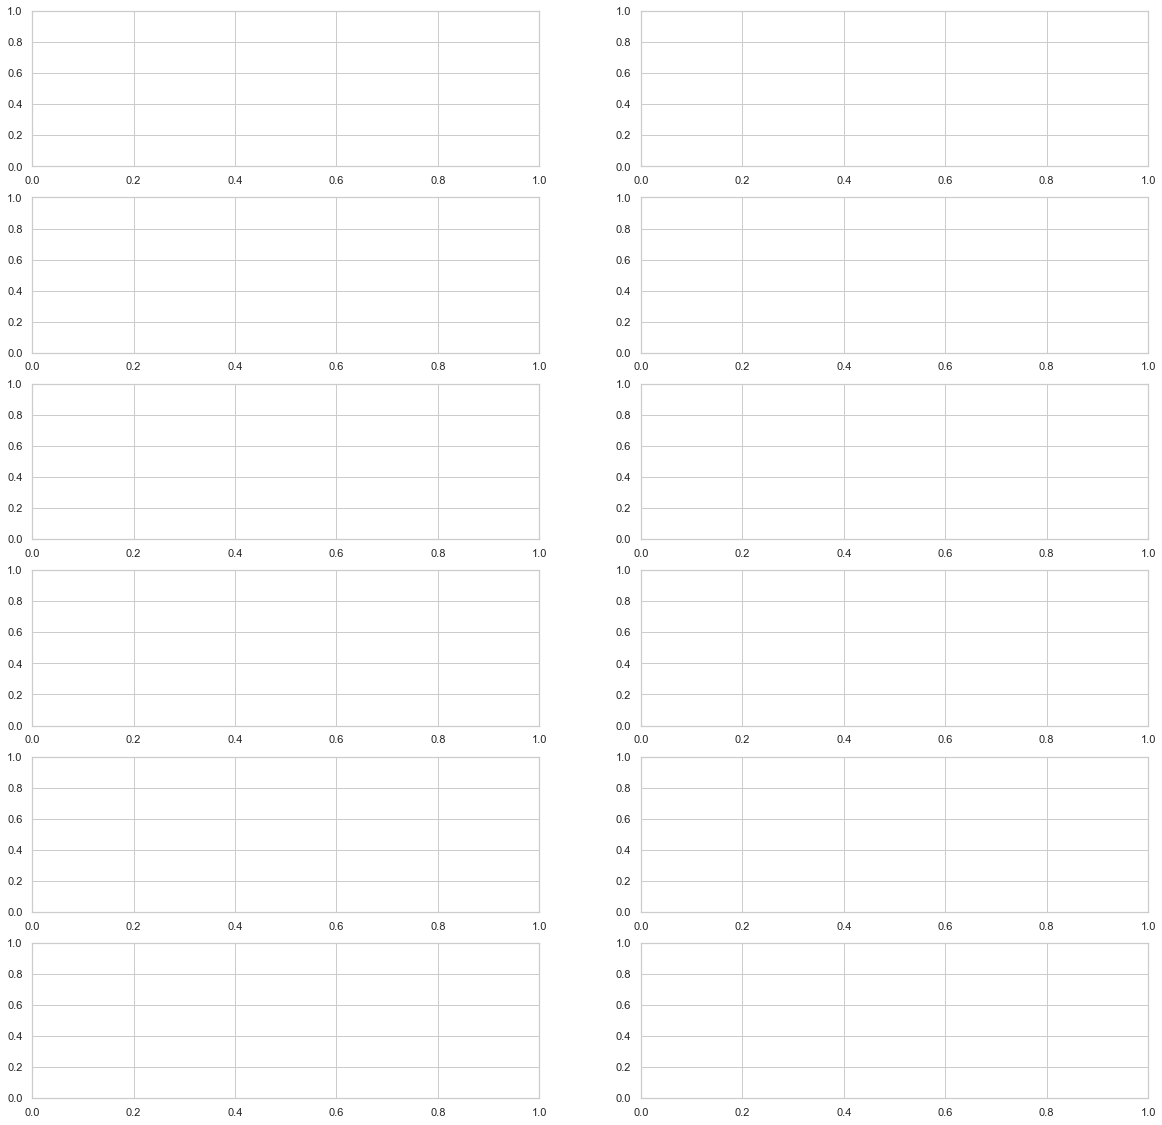

In [254]:
_, ax = plt.subplots(6,2,figsize = (20,20))

print(imgs.shape)
print(imgs.dtype)
prediction = load_model(X_data, training = False)[0].numpy()
prediction = prediction*0.5 + 0.5
#img = (img[0]*0.5 + 0.5).numpy()
ax[i, 0].imshow(imgs[0])
ax[i, 1].imshow(prediction)
ax[i, 0].set_title('Input Photo')
ax[i, 1].set_title('Generated Photo')
ax[i, 0].axis('off')
ax[i, 1].axis('off')
plt.tight_layout()
plt.show()